In [1]:
# implementation of the backpropagation neural network based on numpy
# written by William Li
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import OneHotEncoder

In [2]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [3]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 15468310365967084215
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 1399714407
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 4951477021036589450
 physical_device_desc: "device: 0, name: NVIDIA GeForce MX330, pci bus id: 0000:2b:00.0, compute capability: 6.1"
 xla_global_id: 416903419]

In [ ]:
!cat /proc/meminfo

Please choose between the following 3 data sets (comment out the lines you use)
1. XOR data
2. IRIS data
3. Fashion MNINST data

And then choose the appropriate activation and cost function for the data set.

1. XOR data

In [ ]:
# # this example can also be used instead of loading data from file
# # use the XOR data as input and output
# data=np.array([[0.1,0.1,0.1,0.1],
#  [0.1,0.9,0.1,0.9],
#  [0.9,0.1,0.9,0.1],
#  [0.9,0.9,0.9,0.9]])

# input = data[:,[0,1]]
# output = data[:,[2,3]]

# print(input)
# print(output)

# num_inputs = 2
# num_outputs = 2
# num_training_patterns = 4

[[0.1 0.1]
 [0.1 0.9]
 [0.9 0.1]
 [0.9 0.9]]
[[0.1 0.1]
 [0.1 0.9]
 [0.9 0.1]
 [0.9 0.9]]


2. IRIS data

In [ ]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder

X, y = load_iris(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
quantile_transformer = preprocessing.QuantileTransformer(random_state=0)
input = quantile_transformer.fit_transform(X_train)
test_input = quantile_transformer.transform(X_test)

encoder = OneHotEncoder(sparse=False)
output = encoder.fit_transform(y_train.reshape(-1,1))
test_output = encoder.fit_transform(y_test.reshape(-1,1))

num_inputs = input.shape[1]
num_outputs = output.shape[1]
num_training_patterns = input.shape[0]

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:2593: UserWarning: n_quantiles (1000) is greater than the total number of samples (112). n_quantiles is set to n_samples.
  "n_samples." % (self.n_quantiles, n_samples)


3. Fashion MNIST data

In [5]:
# use the mnist as training / test data
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# choose the number of images to use (out of 60000)
num_train_images = 600
num_test_images = 100

train_images = train_images[:num_train_images] / 255.0
test_images = test_images[:num_test_images] / 255.0

# flatten the images for our neural network
input = train_images.reshape(num_train_images,-1)
test_input = test_images.reshape(num_test_images,-1)
# create output neurons from our training output labels
output = label_binarize(train_labels.reshape(-1),classes=(list(range(10))))

num_inputs = input.shape[1]
num_outputs = output.shape[1]
num_training_patterns = input.shape[0]

In [6]:
def sigmoid(x):
  a = np.where(x<-15,-15,x) # limit input values to less than e.g. -15, otherwise the return statement below will trigger "RuntimeWarning: overflow encountered in power"
  return np.where(a>15,1,np.where(a<=-15,0,1/(1+np.e ** -a)))

def sigmoid_derivative(x):
# expect as input the output of the activation function of a neuron
# as during the backward pass the output of the activation function of a neuron should have been already calculated during the forward pass
  return x*(1-x)

def relu(x):
# it is in fact 'leaky relu'
  return np.where(x>0,x,0.01*x)

def relu_derivative(x):
# it is in fact 'leaky relu'
  return np.where(x>0,1,0.01)

def squared_error(expected, actual):
# take the square of the difference between the expected and actual output of 1 neuron and sum for all output neurons
  return np.square(expected - actual)

def squared_error_derivative(expected, actual):
  return -2 * (expected - actual)

def softmax(x):
  expX = np.exp(x - np.max(x))
  return expX / expX.sum(axis=0, keepdims=True)

def softmax_derivative_for_cross_entropy(x):
# the derivative of softmax together with the cross entropy cost function is 1 in our used computation
  return 1

def cross_entropy(expected, actual):
  return -np.mean(expected * np.log(actual+ 1e-8)) # the 1e-8 has been added to avoid overflow in numpy

def cross_entropy_derivative_for_softmax(expected, actual):
  return -1*(expected - actual)

In [7]:
# the backprogagation neural network defined in a class
class BNN:
    def __init__(self,num_hidden_neurons,learning_rate,momentum,activation,activation_der,cost_function,cost_function_der,batch_size):
        self.num_hidden_neurons = num_hidden_neurons
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.num_hidden_layers=len(num_hidden_neurons)
        self.weights=[]
        self.delta_weights=[]
        self.prev_delta_weights=[]
        self.bias=[]
        self.delta_bias=[]
        self.prev_delta_bias=[]
        self.output=[]
        self.delta=[]
        self.error=0
        self.errors=[]
        self.activation = activation
        self.activation_derivative = activation_der
        self.cost_function = cost_function
        self.cost_function_derivative = cost_function_der
        self.batch_size=batch_size

        np.random.seed(3)
        # initialize weights with random values
        self.weights.append(np.random.randn(self.num_hidden_neurons[0],num_inputs) * np.sqrt(2/num_inputs))
        for h in range(1,self.num_hidden_layers):
          self.weights.append(np.random.randn(self.num_hidden_neurons[h],self.num_hidden_neurons[h-1]) * np.sqrt(2/self.num_hidden_neurons[h-1]))
        self.weights.append(np.random.randn(num_outputs,self.num_hidden_neurons[self.num_hidden_layers-1])* np.sqrt(2/self.num_hidden_neurons[self.num_hidden_layers-1]))
        self.bias.append(np.random.randn(self.num_hidden_neurons[0]) * np.sqrt(2/num_inputs))
        for h in range(1,self.num_hidden_layers):
          self.bias.append(np.random.randn(self.num_hidden_neurons[h]) * np.sqrt(2/self.num_hidden_neurons[h-1]))
        self.bias.append(np.random.randn(num_outputs)* np.sqrt(2/self.num_hidden_neurons[self.num_hidden_layers-1]))
        self.prev_delta_weights.append(np.zeros((self.num_hidden_neurons[0],num_inputs)))
        for h in range(1,self.num_hidden_layers):
          self.prev_delta_weights.append(np.zeros((self.num_hidden_neurons[h],self.num_hidden_neurons[h-1])))
        self.prev_delta_weights.append(np.zeros((num_outputs,self.num_hidden_neurons[self.num_hidden_layers-1])))
        self.prev_delta_bias.append(np.zeros((self.num_hidden_neurons[0])))
        for h in range(1,self.num_hidden_layers):
          self.prev_delta_bias.append(np.zeros((self.num_hidden_neurons[h])))
        self.prev_delta_bias.append(np.zeros((num_outputs)))
        
        # initiialize output and delta of neurons
        for h in range(self.num_hidden_layers+1):
          self.output.append(np.array(0))
          self.delta.append(np.array(0))
          self.delta_weights.append(np.array(0))
          self.delta_bias.append(np.array(0))

    def forward_pass(self,x):
        # input is shape (number of inputs, size of 1 input row). Do a transpose on the input so that we can do a matmul for each input row.
        self.output[0]=self.activation[0](np.matmul(self.weights[0],x.transpose())+self.bias[0])
        for h in range(1,self.num_hidden_layers+1):
          self.output[h]=self.activation[h](np.matmul(self.weights[h],self.output[h-1])+self.bias[h])
        
    def backward_pass(self,x,y,update):
        for h in range(self.num_hidden_layers,-1,-1):
          if (h==self.num_hidden_layers):
            partial_delta = self.cost_function_derivative(y.transpose(),self.output[self.num_hidden_layers])
          else:
            partial_delta = np.matmul(self.weights[h+1].transpose(),self.delta[h+1])
          act_deriv = self.activation_derivative[h](self.output[h])
          if (h==0):
            output_prev_layer = x
          else:
            output_prev_layer = self.output[h-1]
          self.delta[h]=act_deriv * partial_delta
          self.delta_weights[h] = np.outer(self.delta[h],output_prev_layer)
          self.delta_bias[h]=self.delta[h]
          if (update==True):
            self.weights[h] = self.weights[h] - ((1/self.batch_size) * self.learning_rate * self.delta_weights[h]) - ((1/self.batch_size) * self.momentum * self.prev_delta_weights[h])
            self.bias[h] = self.bias[h] - ((1/self.batch_size) * self.learning_rate * self.delta_bias[h]) - ((1/self.batch_size)*(self.momentum * self.prev_delta_bias[h]))
            self.prev_delta_weights[h] = self.delta_weights[h]
            self.prev_delta_bias[h] = self.delta_bias[h]
          else:
            self.delta_weights[h] = self.prev_delta_weights[h] + self.delta_weights[h]
            self.delta_bias[h]= self.prev_delta_bias[h] + self.delta_bias[h]
            self.prev_delta_weights[h] = self.delta_weights[h]
            self.prev_delta_bias[h] = self.delta_bias[h]

    def train(self,num_epochs,num_training_patterns,batch_size,tolerance,num_epochs_print_error):
      for n in range(num_epochs):
        update=True
        error = 0
        for i in range(num_training_patterns):
          if (batch_size>1):
              if ((i % batch_size == 0) or (i==num_training_patterns-1)):
                update=True
              else:
                update=False
          self.forward_pass(input[i])
          error = self.cost_function(output[i].transpose(),self.output[self.num_hidden_layers])
          self.error = self.error + error
          self.backward_pass(input[i],output[i],update)
        self.error = np.sum(self.error) / num_training_patterns
        self.errors.append(self.error)
        if self.error < tolerance:
          stop_training = True
          print("epoche = ",n+1," , error = ",self.error)
          break
        if ((n+1) % num_epochs_print_error == 0):  
          print("epoche = ",n+1," , error = ",self.error)

In [8]:
# set the parameters and do the backpropagation neural network training
num_hidden_neurons = [128]
learning_rate=0.1
momentum=0.9
# activation functions and their corresponding derivatives can be set for each hidden and the output layer
# so, e.g. if there is 1 hidden layer, please set 1 activation function for the hidden layer and 1 activation function for the output layer.
activation=[relu,softmax]
activation_der=[relu_derivative,softmax_derivative_for_cross_entropy]
cost_function=cross_entropy
cost_function_der=cross_entropy_derivative_for_softmax
# activation=[sigmoid,sigmoid]
# activation_der=[sigmoid_derivative,sigmoid_derivative]
# cost_function=squared_error
# cost_function_der=squared_error_derivative
batch_size=50

if (len(num_hidden_neurons) == len(activation)-1):
  bnn = BNN(num_hidden_neurons,learning_rate,momentum,activation,activation_der,cost_function,cost_function_der,batch_size)

  num_epochs =5000
  tolerance=0.0001
  num_epochs_print_error=50
  bnn.train(num_epochs,num_training_patterns,batch_size,tolerance,num_epochs_print_error)
else:
  print("Please set the correct number of activation functions based on the number of hidden layers.")


epoche =  50  , error =  0.5444045368614907
epoche =  100  , error =  0.3443092339001706
epoche =  150  , error =  0.2612928709830639
epoche =  200  , error =  0.19693806452177023
epoche =  250  , error =  0.0953377424528901
epoche =  300  , error =  0.08304676459468067
epoche =  350  , error =  0.043032867117418654
epoche =  400  , error =  0.03077284652088183
epoche =  450  , error =  0.03692838118096768
epoche =  469  , error =  1.5383692353307042e-05


<function matplotlib.pyplot.show>

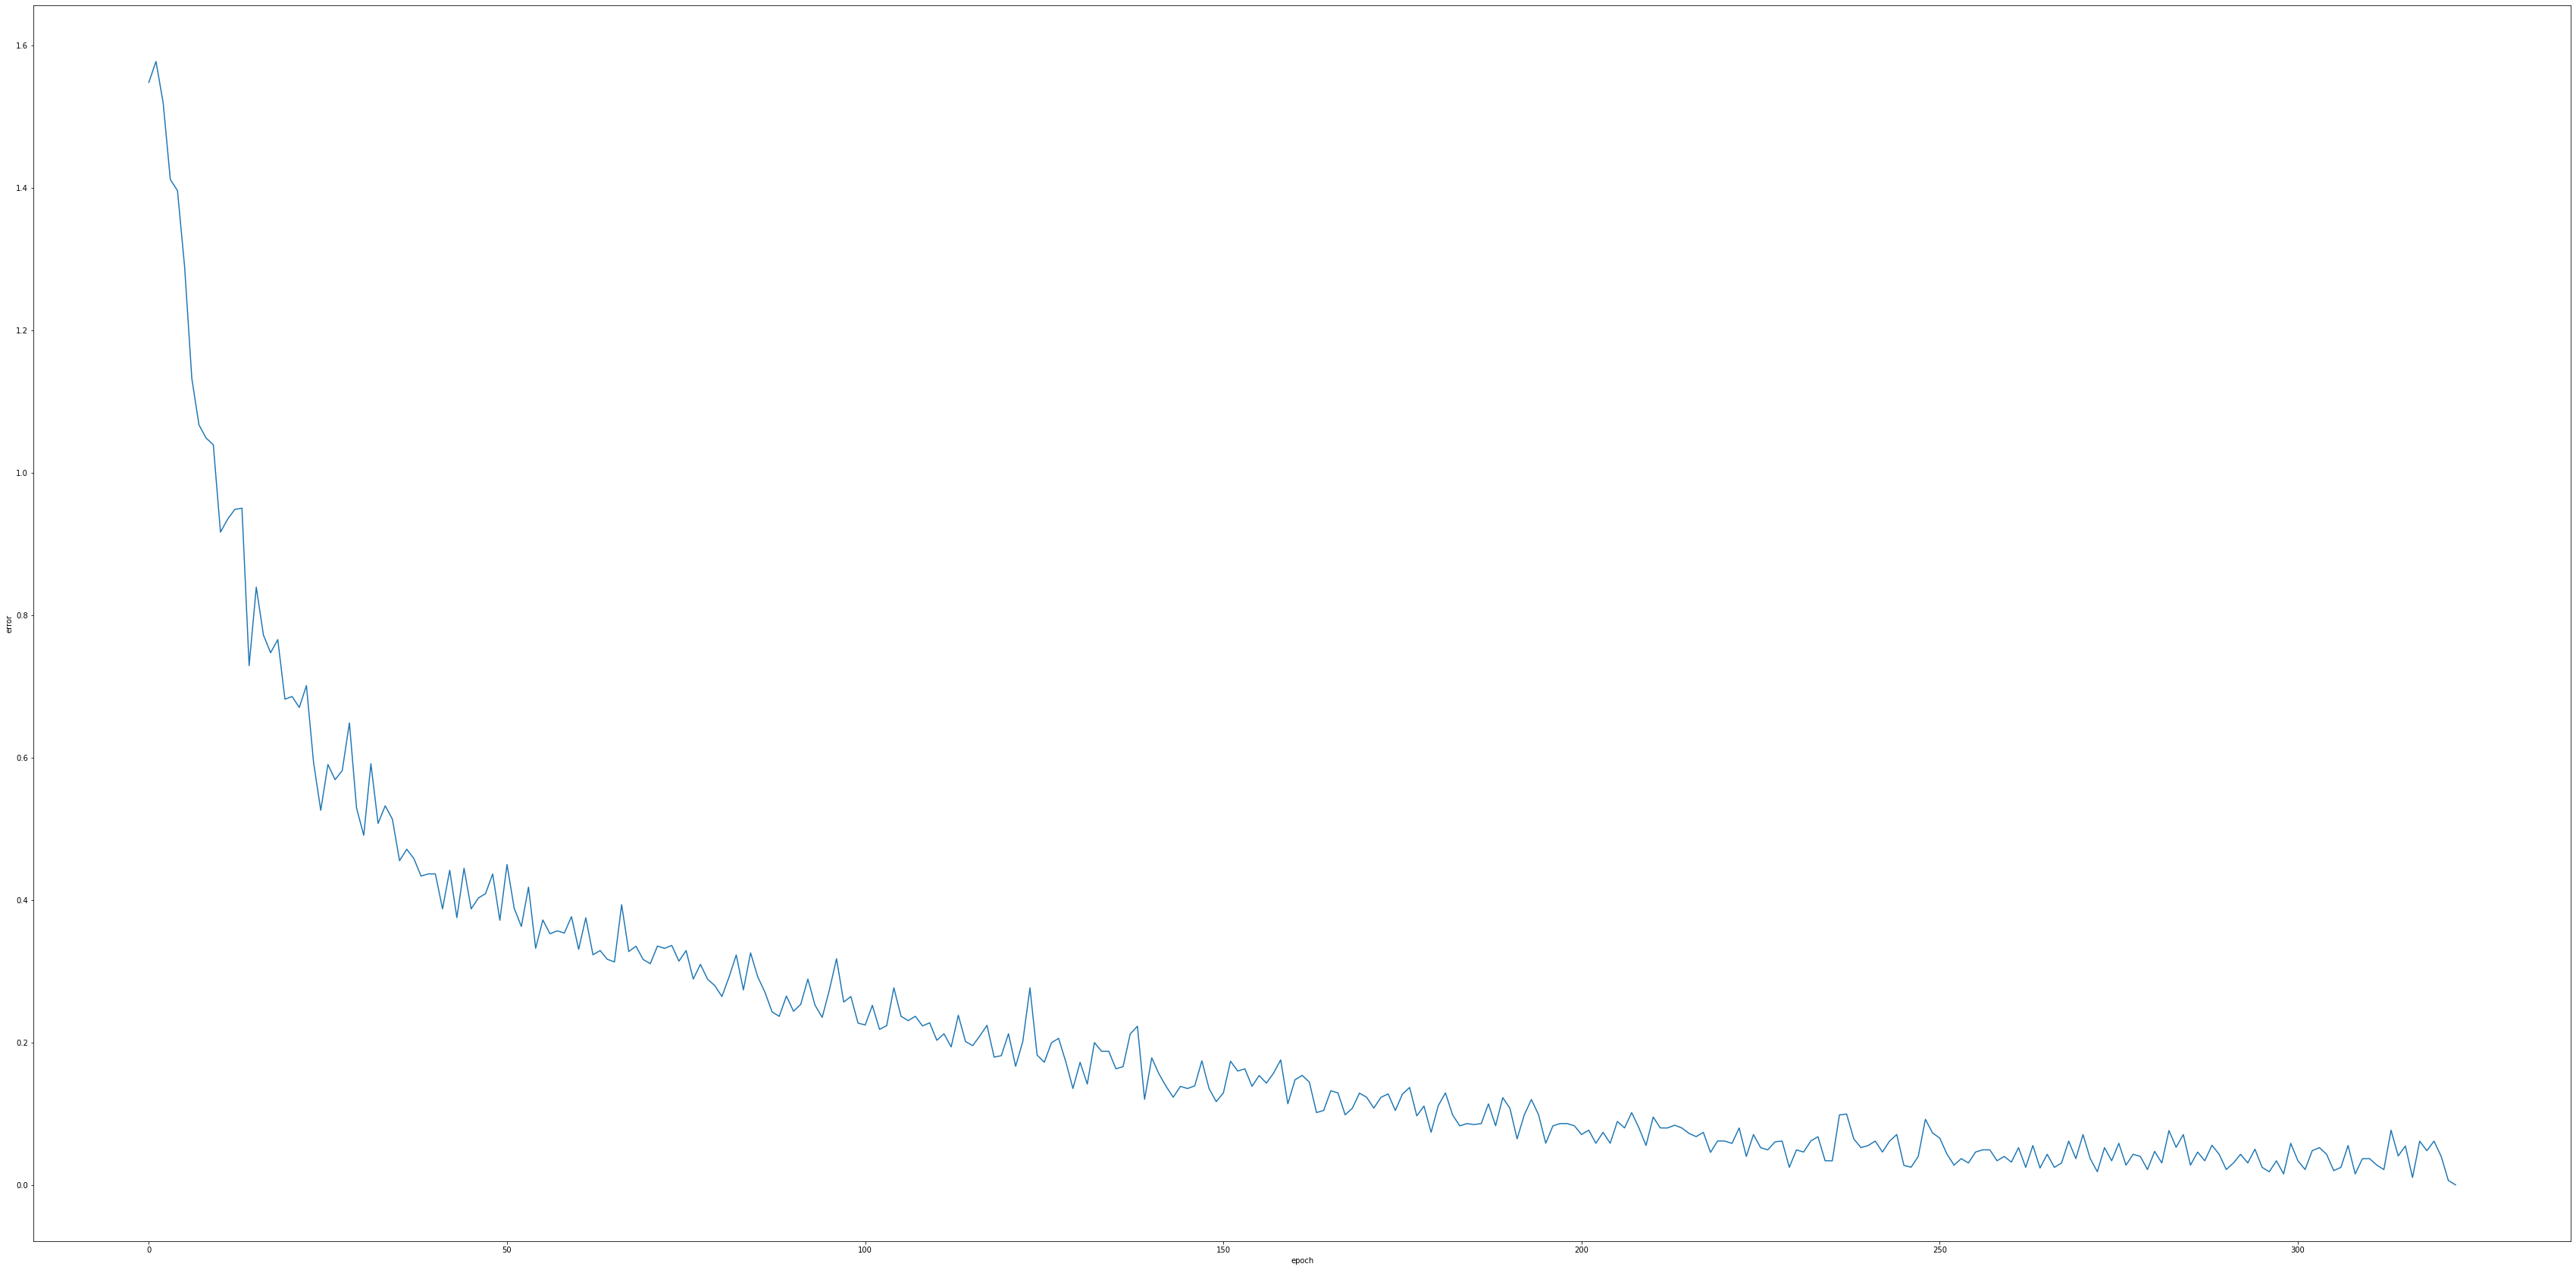

In [ ]:
# plot the error
x=np.arange(len(bnn.errors))
y=bnn.errors
plt.figure(figsize=(60,30))
plt.plot(x,y)
plt.xlabel("epoch")
plt.ylabel("error")
plt.show

Use this for the XOR data to test the trained neural network

In [ ]:
# test XOR data
for i in range(num_training_patterns):
  bnn.forward_pass(input[i])
  print("test input:  ",input[i])
  print("test output: ",bnn.output[bnn.num_hidden_layers])


test input:   [0.1 0.1]
test output:  [0.09733801 0.10125332]
test input:   [0.1 0.9]
test output:  [0.10668046 0.89985621]
test input:   [0.9 0.1]
test output:  [0.9034733  0.10151104]
test input:   [0.9 0.9]
test output:  [0.88927312 0.89628085]


Use this for the IRIS data to test the trained neural network

In [ ]:
# test IRIS data
num_correct_pred = 0
for i in range(len(test_input)):
  bnn.forward_pass(test_input[i])
  if (np.argmax(test_output[i])==np.argmax(bnn.output[bnn.num_hidden_layers])):
    num_correct_pred = num_correct_pred + 1
  #print("actual output: ",test_output[i],", actual output: ",np.argmax(test_output[i])," ,test output: ",np.argmax(bnn.output[bnn.num_hidden_layers]))
print("accuracy = ",num_correct_pred/len(test_input))

accuracy =  0.9736842105263158


Use this for the Fashion MNIST data  to test the trained neural network

In [9]:
# test Fashion MNIST data
num_correct_pred = 0
for i in range(len(test_images)):
  bnn.forward_pass(test_input[i])
  if (test_labels[i]==np.argmax(bnn.output[bnn.num_hidden_layers])):
    num_correct_pred = num_correct_pred + 1
  #print("actual output: ",test_output[i],", actual output: ",np.argmax(test_output[i])," ,test output: ",np.argmax(bnn.output[bnn.num_hidden_layers]))
print("accuracy = ",num_correct_pred/len(test_input))

accuracy =  0.76
